In [2]:
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.utils import save_image
import torchvision.models as tvmodels
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

sys.path.insert(0, "../src")
import exlib
from exlib.explainers import *
from exlib.modules import *
from exlib.datasets.abdomen_organs import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
DATA_DIR = "/home/antonxue/foo/data/abdomen_exlib/"
train_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="train")
test_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="test")

In [4]:
model = AbodmenModel(in_channels=3, out_channels=3)
model.eval();

In [5]:
x, olabel, glabel = train_dataset[2]
y = model(x[None,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

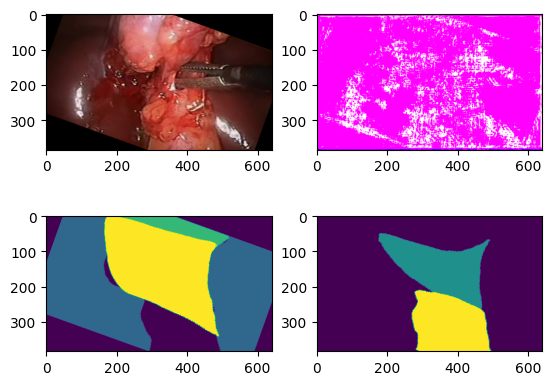

In [6]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(40 * y[0].detach().numpy().transpose(1,2,0))
ax[1,0].imshow(30 * olabel.numpy().transpose(1,2,0))
ax[1,1].imshow(40 * glabel.numpy().transpose(1,2,0))

In [7]:
x, olabel, glabel = test_dataset[2]
y = model(x[None,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

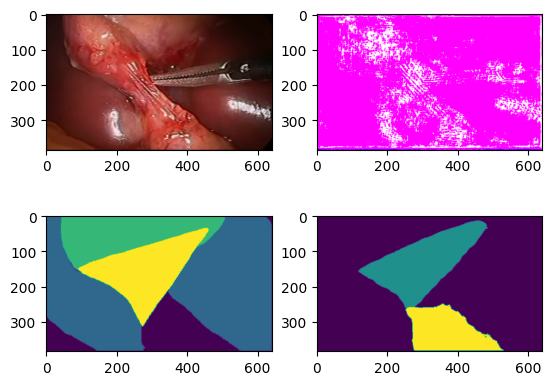

In [8]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(40 * y[0].detach().numpy().transpose(1,2,0))
ax[1,0].imshow(30 * olabel.numpy().transpose(1,2,0))
ax[1,1].imshow(40 * glabel.numpy().transpose(1,2,0))

In [9]:
# Try an explainer

In [10]:
explainer = TorchImageSegIntGrad(model)

In [11]:
X = torch.stack([x,x])
intg = explainer(X, labels=[0,2], num_steps=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

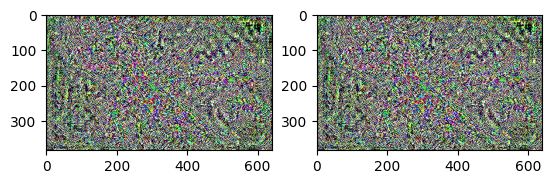

In [12]:
plt.figure()
fig, ax = plt.subplots(1,2)
ax[0].imshow(intg.attributions.detach()[0].numpy().transpose(1,2,0))
ax[1].imshow(intg.attributions.detach()[1].numpy().transpose(1,2,0))

In [13]:
# Use their models. 

In [14]:
import segmentation_models_pytorch as smp

In [15]:
# Load the model
smp_model = smp.Unet(
    encoder_name="resnet34",    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,              # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                  # model output channels (number of classes in your dataset)
    activation='softmax2d'
)

state_dict_path = "/home/antonxue/foo/real_drs/saved_models/weiqiu_model.pt"
state_dict = torch.load(state_dict_path, map_location="cpu")
smp_model.load_state_dict(state_dict["model"])
smp_model.eval()
;

''

In [17]:
x, olabel, glabel = test_dataset[0]

x_go = x.clone()
x_go[2:,:,] = 1.0
x_go = x_go *  (glabel == 1)

x_nogo = x.clone()
x_nogo[0,:,:] = 1.0
x_nogo = x_nogo * (glabel == 2)

x_gonogo = (1 - (glabel == 1).int() - (glabel == 2).int()) * x + x_go + x_nogo

In [18]:
smp_explainer = TorchImageSegIntGrad(smp_model)

In [19]:
X = torch.stack([x,x,x])
smp_intg = smp_explainer(X, labels=[0,1,2], num_steps=16, progress_bar=True)

100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


In [20]:
alphas = smp_intg.attributions.cpu().detach()
q = alphas.view(-1).quantile(0.95)
pas = (alphas.abs() > q) * 1.0

<Figure size 640x480 with 0 Axes>

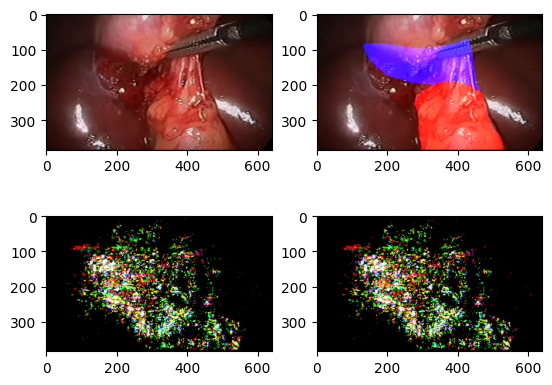

In [21]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(x_gonogo.numpy().transpose(1,2,0))

# ax[0,1].imshow(pas[0].numpy().transpose(1,2,0))
ax[1,0].imshow(pas[1].numpy().transpose(1,2,0))
ax[1,1].imshow(pas[2].numpy().transpose(1,2,0))

In [25]:
xfile = test_dataset.image_filenames[0]
xfile

'AdnanSet_LC_100_002.png'

In [28]:
dump_dir = "/home/antonxue/foo/test/dump/"
save_image(x, dump_dir + xfile)
save_image(x_gonogo, dump_dir + xfile + ".gonogo.png")
save_image(pas[0], dump_dir + xfile + ".intgrad.png")